## Create RFM dataset

In [405]:
# Import libraries
import numpy as np 
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [406]:
# Import clean_data
customer_data = pd.read_excel(r'C:\Users\argyr\OneDrive\Υπολογιστής\Diplvm\Giftware dataset\clean_data.xlsx')
customer_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01,1.25,13085,United Kingdom


In [407]:
customer_data.shape

(800909, 8)

In [408]:
# In order to calculate the monetary value for each customer we first need to create 'TotalValue' column
customer_data["TotalValue"] = customer_data["Quantity"] * customer_data["Price"]

In [409]:
# In order to calculate the recency value we need to find out which was the last transaction date
last_transaction_date = customer_data["InvoiceDate"].max()
print(last_transaction_date)

2011-12-09 00:00:00


In [410]:
# Set date 12/10/20211, which is one day after the last transaction date, as today_date
today_date = dt.datetime(2011,12,10)

In [411]:
# Group by Customer ID and calculate RFM values
#rfm = customer_data.groupby("Customer ID").agg({"InvoiceDate": lambda x :(today_date-x.max()).days,
                               #"Invoice": lambda x : x.nunique(),
                               #"TotalValue":lambda x : x.sum()})
#rfm.head()

In [412]:
# Group by Customer ID and calculate RFM values
rfm = customer_data.groupby(["Customer ID"], as_index=False).agg({"InvoiceDate": lambda x :(today_date-x.max()).days,
                               "Invoice": lambda x : x.nunique(),
                               "TotalValue":lambda x : x.sum()})
rfm.head()

,Customer ID,InvoiceDate,Invoice,TotalValue
0,12346,432,12,368.36
1,12347,3,8,4921.53
2,12348,76,5,2019.40
3,12349,19,5,4419.49
4,12350,311,1,334.40


In [413]:
# Rename columns accordingly
rfm.columns = ["Customer ID", "Recency", "Frequency", "Monetary"]
rfm.head()

,Customer ID,Recency,Frequency,Monetary
0,12346,432,12,368.36
1,12347,3,8,4921.53
2,12348,76,5,2019.40
3,12349,19,5,4419.49
4,12350,311,1,334.40


In [414]:
rfm["Recency"] = rfm["Recency"].astype(float)
rfm["Frequency"] = rfm["Frequency"].astype(float)
rfm["Monetary"] = rfm["Monetary"].astype(float).round(2)

In [415]:
rfm.shape

(5848, 4)

In [416]:
#def jitter(a_series, noise_reduction=1000000):
 #   return (np.random.random(len(a_series))*a_series.std()/noise_reduction)-(a_series.std()/(2*noise_reduction))

#rfm["Frequency"] = rfm["Frequency"] + jitter(rfm["Frequency"])

### Create RFM score

In [417]:
# Claculate RFM scores
# Using pd.qcut() categorize each customer into 5 bins based on their value in each one of the metrics R,F,M
rfm["Recency_Score"] = pd.qcut(rfm["Recency"], 5, labels = [5, 4 , 3, 2, 1])
rfm["Frequency_Score"]= pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels = [1, 2, 3, 4, 5])
rfm["Monetary_Score"] = pd.qcut(rfm['Monetary'], 5, labels = [1, 2, 3, 4, 5])
rfm.head()

,Customer ID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score
0,12346,432.0,12.0,368.36,1,5,2
1,12347,3.0,8.0,4921.53,5,4,5
2,12348,76.0,5.0,2019.40,3,3,4
3,12349,19.0,5.0,4419.49,5,3,5
4,12350,311.0,1.0,334.40,2,1,2


In [418]:
rfm["RFM_Score"] = rfm["Recency_Score"].astype(str) + rfm["Frequency_Score"].astype(str) + rfm["Monetary_Score"].astype(str)
rfm.head()

,Customer ID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score
0,12346,432.0,12.0,368.36,1,5,2,152
1,12347,3.0,8.0,4921.53,5,4,5,545
2,12348,76.0,5.0,2019.40,3,3,4,334
3,12349,19.0,5.0,4419.49,5,3,5,535
4,12350,311.0,1.0,334.40,2,1,2,212


In [419]:
rfmdata = rfm.to_csv(r'C:\Users\argyr\OneDrive\Υπολογιστής\Diplvm\Giftware dataset\rfm_data_ipynb.csv', index=False)

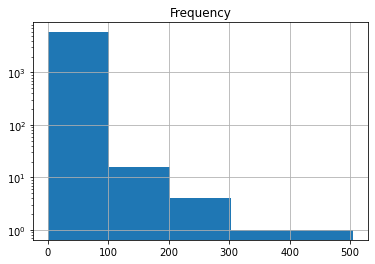

In [420]:
# We better not split customers in 5 equal-in-size categories wrt frequency:
# their distribution is not uniform:
data = rfm["Frequency"].astype(float)
df = pd.DataFrame(data)
hist = df.hist(bins=5, log=True)

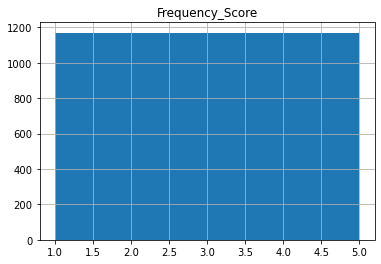

In [421]:
# This should be reflective of the above histogram
data = rfm["Frequency_Score"].astype(float)
df = pd.DataFrame(data)
hist = df.hist(bins=5)

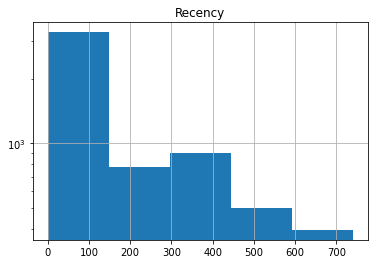

In [422]:
# Check the Recency now:
data = rfm["Recency"].astype(float)
df = pd.DataFrame(data)
hist = df.hist(bins=5, log=True)

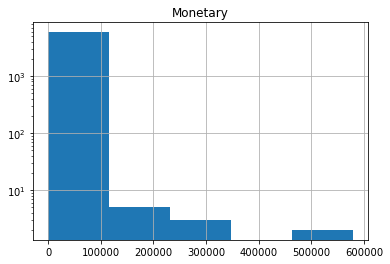

In [423]:
# ... and now the Monetary:
data = rfm["Monetary"].astype(float)
df = pd.DataFrame(data)
hist = df.hist(bins=5, log=True)

In [424]:
# ... for this reason it would be preferable to cluster recency, frequency, and monetary via kmeans.
# The code below is kmeans Python code for Power BI.
# We can run it in Power BI and in Jupyter and come up with the scores individually.
# If the process was deterministic, i.e. if the k centers of the k clusters were not 
# initialised randomly, then there would be no problem, since the same code would produce
# the same results in each tool. But the clusters are indeed initialised randomly.
# ...
# We could try to run this code at each tool and try to "sync" their results, but this would take time. 
# Instead we will produce the results here (they may as well had been produced in Power BI),
# and feed the produced dataset to Power BI, as if *it* had produced them, which is perfectly capable of,
# and which we would, if only for the randomness inherent to kmeans.
#
# The other problem is that since the process is random: which is the correct clustering?
# Run if for N times and take that which is the most frequent.

In [425]:
def my_iterative_kmeans(rfm, rfm_column_name, num_runs, n_clusters):
        
    uids = []
    rfms = []
    
    # python produces 0:4 labels, we want 1:5
    labels_mapping = {0:1, 1:2, 2:3, 3:4, 4:5}
    
    for i in range(num_runs):

        kmeans = KMeans(n_clusters=n_clusters).fit(rfm[[rfm_column_name]])
        rfm[rfm_column_name+'_clustered'] = kmeans.labels_
        
        # https://stackoverflow.com/questions/44888415/how-to-set-k-means-clustering-labels-from-highest-to-lowest-with-python
        idx = np.argsort(kmeans.cluster_centers_.sum(axis=1))
        lut = np.zeros_like(idx)
        lut[idx] = np.arange(n_clusters)
        
        # Map from 0-4 to 1-5
        lut[kmeans.labels_] = [labels_mapping[i] for i in lut[kmeans.labels_]]
        rfm[rfm_column_name+'_clustered'] = [labels_mapping[i] for i in rfm[rfm_column_name+'_clustered']]

        uid = [sum(lut[kmeans.labels_] == 1), 
               sum(lut[kmeans.labels_] == 2), 
               sum(lut[kmeans.labels_] == 3), 
               sum(lut[kmeans.labels_] == 4), 
               sum(lut[kmeans.labels_] == 5)],
              
        uids.append(''.join(str(uid)))
        rfms.append(rfm)
        
    return uids,rfms

In [426]:
# Run 5-means ntimes for each column

ntimes = 1000
nclusters = 5

mik_r = my_iterative_kmeans(rfm, 'Recency',   ntimes, nclusters)
mik_f = my_iterative_kmeans(rfm, 'Frequency', ntimes, nclusters)
mik_m = my_iterative_kmeans(rfm, 'Monetary',  ntimes, nclusters)

# counts
counts_r = {}
counts_f = {}
counts_m = {}

for i in mik_r[0]:
  counts_r[i] = (counts_r[i] + 1) if (i in counts_r) else 1
for i in mik_f[0]:
  counts_f[i] = (counts_f[i] + 1) if (i in counts_f) else 1
for i in mik_m[0]:
  counts_m[i] = (counts_m[i] + 1) if (i in counts_m) else 1

In [427]:
[counts_r, counts_f, counts_m]

[{'([2864, 763, 592, 1028, 601],)': 15,
  '([2581, 916, 719, 1032, 600],)': 6,
  '([2864, 763, 592, 1029, 600],)': 121,
  '([2722, 837, 660, 1028, 601],)': 6,
  '([2824, 783, 612, 1028, 601],)': 37,
  '([2856, 766, 597, 1029, 600],)': 40,
  '([2874, 758, 587, 1029, 600],)': 229,
  '([2818, 772, 629, 1029, 600],)': 12,
  '([2836, 777, 606, 1029, 600],)': 20,
  '([2824, 776, 619, 1028, 601],)': 37,
  '([2856, 766, 597, 1028, 601],)': 9,
  '([2796, 785, 638, 1029, 600],)': 31,
  '([2856, 766, 597, 1023, 606],)': 2,
  '([2836, 777, 606, 1028, 601],)': 10,
  '([2856, 757, 606, 1028, 601],)': 13,
  '([2824, 783, 612, 1029, 600],)': 156,
  '([2824, 776, 619, 1029, 600],)': 76,
  '([2722, 837, 660, 1029, 600],)': 12,
  '([2824, 770, 625, 1028, 601],)': 3,
  '([2824, 783, 612, 1023, 606],)': 4,
  '([2739, 827, 653, 1029, 600],)': 6,
  '([2824, 776, 619, 1023, 606],)': 7,
  '([2581, 916, 719, 1031, 601],)': 25,
  '([2856, 757, 606, 1029, 600],)': 39,
  '([2784, 790, 645, 1029, 600],)': 6,
  '([2

In [428]:
# find uid with max counts
# max(counts_r, key=counts_r.get)
# This gives the string located in `uids` that is most frequent
# https://stackoverflow.com/a/280156

# We want to obtain one such clustering that is stored in the mik_*[1] element of the `my_iterative_kmeans` return object.
# These are the rid, fid, and mids
# https://stackoverflow.com/a/176921
rid = mik_r[0].index(max(counts_r, key=counts_r.get))
fid = mik_f[0].index(max(counts_f, key=counts_f.get))
mid = mik_m[0].index(max(counts_m, key=counts_m.get))

# These clusterings are saved here:
# mik_r[1][rid]
# mik_f[1][fid]
# mik_m[1][mid]

In [429]:
rfm2 = rfm[["Customer ID", "Recency_clustered", "Frequency_clustered", "Monetary_clustered"]]
rfm2.head()

,Customer ID,Recency_clustered,Frequency_clustered,Monetary_clustered
0,12346,2,5,1
1,12347,1,1,1
2,12348,1,1,1
3,12349,1,1,1
4,12350,3,1,1


In [430]:
rfmdata_clustered = rfm2.to_csv(r'C:\Users\argyr\OneDrive\Υπολογιστής\Diplvm\Giftware dataset\rfm_data_clustered_ipynb.csv', index=False)